In [1]:
#initialisation for easy testing
import Bio
import numpy as np
import sys
import os
import networkx as nx
import random as random
from tqdm import tqdm # loading bar
from utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, fill_graph,new_sp_approxi_combi
from utils_copy import convert_to_desired_format_nr_version, compute_cost, my_traversal_simply, extend_alignment_chaos, find_min_span_edges_testing, parse_fasta_multiple_remove_n

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5

filename='brca1-testseqs.fasta'
filename2='brca1-full.fasta'
brca_seqs_work_please,names=parse_fasta_multiple(filename)
brca_seqs_long=parse_fasta_multiple_remove_n(filename2)

#print(brca_seqs_work_please)
print(brca_seqs_long[0][0:7])

#just testing if the removal of n worked!
sequence=brca_seqs_long[0][7]
contains_n = any(letter.lower() == 'n' for letter in sequence)
if contains_n:
    print("The sequence contains at least one 'n' or 'N'.")
else:
    print("The sequence does not contain 'n' or 'N'.")

brca1_bos_taurus
brca1_canis_lupus
brca1_gallus_gallus
brca1_homo_sapiens
brca1_macaca_mulatta
brca1_mus_musculus
brca1_pan_troglodytes
brca1_rattus_norvegicus
['atggatttatctgcggatcatgttgaagaagtacaaaatgtcctcaatgctatgcagaaaatcttagagtgtccaatatgtctggagttgatcaaagagcctgtctctacaaagtgtgaccacatattttgcaaattttgtatgctgaaacttctcaaccagaagaaagggccttcacaatgtcctttgtgtaagaatgatataaccaaaagaagcctacaagaaagtacaagatttagtcaacttgttgaagagctgttgaagatcattcatgcttttgagcttgacacaggattgcagtttgcaaacagctataacttttcgagaaaggaagataactctcctgagcatctgaaggaggaagtttctataatccaaagtatgggctaccggaaccgggccaaaagactttggcagagtgaacctgaaaatcctaccttgcaggaaaccagtcttactgtcgaactctctaaccttggaattgtcagatctctgaggacaaagcagcagacacaatctcagaataagtccgtctacattgaattgggatctgattcttctgaagacacagttaataaggccagttatttcagtgtgggagaccatgaattgttagaaatcacccctcaaggagccaaggccaagaccaatttgaatcctgcagaaaaggctgcttgtgagttttctgagaaggacataacaaatactgaacatcatcaactcagtattaaagatctgatcaccacccagaagcatgcaactgagacgcatccagaaaagtatcagggtatttctgtttcagactttcacgtggagccatgtggcacagatactcatg

In [2]:
filename_n='n_containing_seqs_short.fasta'
sekk,namm=parse_fasta_multiple_remove_n(filename_n)
print(sekk)
sequence=sekk[0]
contains_n = any(letter.lower() == 'n' for letter in sequence)
if contains_n:
    print("The sequence contains at least one 'n' or 'N'.")
else:
    print("The sequence does not contain 'n' or 'N'.")


['agttccgaaaggctagcgctaggcgcc', 'atggatttatctgctcttcg', 'tgcatgctgaaacttctcaacca']
The sequence does not contain 'n' or 'N'.


In [3]:
def new_sp_approxi_combi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False,layout="spring"):
    # STEP 1: Find the center string
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # loop over all distinct pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
              matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2))
    print(matrix)
    matrix_for_MST=matrix 
    matrix_for_MST=convert_to_desired_format_nr_version(matrix_for_MST)
    min_span_edges=find_min_span_edges_testing(matrix_for_MST)
    print(matrix_for_MST)
    print(min_span_edges)

    max_indices = np.where(matrix == np.max(matrix))
    max_row_index = max_indices[0][0]
    print(max_row_index)

    #need to use the my_transversal_simply to get transversal order but still use get_visiting_order to put edges in the graph!
    G=fill_graph(min_span_edges,str(int(max_row_index)),layout) #str(int(np.argmin(matrix.sum(axis = 1)))) to get the min arg as the starting point.
    alignment_pairs,index_dict=my_traversal_simply(G,str(int(max_row_index)))
    print(alignment_pairs)
    print(index_dict)

     # STEP 2: Construct alignment M
    M: list[list[str]] = [[letter] for letter in [*seqs[int(max_row_index)]]]
    print("M right now:")
    print(M)
    print("seqs right now")
    print(seqs)
    cost_list = []
    for key,value in alignment_pairs.items(): #was just seqs bebore
        #you need here to get the pairs from the new dict instead
        cost = linear_C(gap_cost, score_matrix, seqs[int(value)], seqs[int(key)]) #was just seqs before
        print("\n now aligning...."+str(seqs[int(value)])+ " and "+ str(seqs[int(key)]))
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(seqs[int(value)], seqs[int(key)], cost, score_matrix, gap_cost)
        str1_nr=value
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str]
        #here you need to provide the nr of the sequences to be able to index in the indexing dict in the extend_alignment_chaos func
        A = [list(e) for e in zip(alignment1,alignment2)]
        print("A right now is: "+str(A))
        print("M right now: "+str(M))
        # extend
        Mk = extend_alignment_chaos(M,str1_nr, A,index_dict) #needs the chaos version
        M = Mk
    
    # ACTUALLY COMPUTE (approximate) COST
    total_cost = compute_cost(M, score_matrix, gap_cost)
    return total_cost, M, matrix_for_MST,G

[[ 0. 74. 65.]
 [74.  0. 51.]
 [65. 51.  0.]]
this is E (sorted matrix without any stars yet): 
[['' '51' '1' '2']
 ['' '65' '0' '2']
 ['' '74' '0' '1']]

 
 this is it 1
before anything happens: tree1_id is 1 and tree2_id is 2
51 1 2
in namedict, before merging we have the numbers: 1 and 2
in namedict, now we have the numbers: 1 and 1
and the whole dict is:{'0': 0, '1': 1, '2': 1}

 
 this is it 2
before anything happens: tree1_id is 0 and tree2_id is 1
65 0 2
in namedict, before merging we have the numbers: 0 and 1
in namedict, now we have the numbers: 0 and 0
and the whole dict is:{'0': 0, '1': 0, '2': 0}
[['' '74' '0' '1']
 ['' '65' '0' '2']
 ['' '51' '1' '2']]
[['*' '51' '1' '2']
 ['*' '65' '0' '2']
 ['' '74' '0' '1']]
0


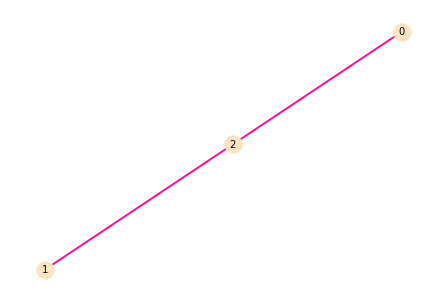

Neighbors of node 0: ['2']
Neighbors of node 1: ['2']
Neighbors of node 2: ['1', '0']
{'2': '0', '1': '2'}
{'2': '0', '1': '2'}
{'0': '0', '2': '1', '1': '2'}
M right now:
[['a'], ['g'], ['t'], ['t'], ['c'], ['c'], ['g'], ['a'], ['a'], ['a'], ['g'], ['g'], ['c'], ['t'], ['a'], ['g'], ['c'], ['g'], ['c'], ['t'], ['a'], ['g'], ['g'], ['c'], ['g'], ['c'], ['c']]
seqs right now
['agttccgaaaggctagcgctaggcgcc', 'atggatttatctgctcttcg', 'tgcatgctgaaacttctcaacca']

 now aligning....agttccgaaaggctagcgctaggcgcc and tgcatgctgaaacttctcaacca
A right now is: [['a', 't'], ['g', 'g'], ['t', 'c'], ['-', 'a'], ['t', 't'], ['-', 'g'], ['c', 'c'], ['c', 't'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['a', 'a'], ['g', '-'], ['g', '-'], ['c', 'c'], ['t', 't'], ['a', '-'], ['g', '-'], ['c', 't'], ['g', '-'], ['c', 'c'], ['t', 't'], ['a', 'c'], ['g', 'a'], ['g', 'a'], ['c', 'c'], ['g', '-'], ['c', 'c'], ['c', 'a']]
M right now: [['a'], ['g'], ['t'], ['t'], ['c'], ['c'], ['g'], ['a'], ['a'], ['a'], ['g'], ['g'], ['c

(252,
 [['-', '-', 'a'],
  ['a', 't', 't'],
  ['g', 'g', 'g'],
  ['t', 'c', 'g'],
  ['-', 'a', 'a'],
  ['t', 't', 't'],
  ['-', 'g', '-'],
  ['c', 'c', 't'],
  ['c', 't', 't'],
  ['g', 'g', '-'],
  ['a', 'a', '-'],
  ['a', 'a', 'a'],
  ['a', 'a', 't'],
  ['g', '-', '-'],
  ['g', '-', '-'],
  ['c', 'c', 'c'],
  ['t', 't', 't'],
  ['a', '-', '-'],
  ['g', '-', '-'],
  ['c', 't', 'g'],
  ['g', '-', '-'],
  ['c', 'c', 'c'],
  ['t', 't', 't'],
  ['a', 'c', 'c'],
  ['g', 'a', '-'],
  ['g', 'a', 't'],
  ['c', 'c', 't'],
  ['g', '-', '-'],
  ['c', 'c', 'c'],
  ['c', 'a', 'g']],
 array([['', '74', '0', '1'],
        ['', '65', '0', '2'],
        ['', '51', '1', '2']], dtype='<U11'),
 <networkx.classes.graph.Graph at 0x21bbee74f70>)

In [4]:
#running it!! (not ruining it hopefully :P )

new_sp_approxi_combi(sekk,score_matrix,gap_cost)